In [202]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
from scipy.spatial.distance import cdist

import anndata as ad
import pandas as pd
import sys

module_pth = "/home/alma/w-projects/ccf/src"
if module_pth not in sys.path:
    sys.path.append(module_pth)
    

import models as m
import methods as f

import preprocess as pp

import os.path as osp
import os
from PIL import Image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [179]:
from matplotlib import rcParams
rcParams["figure.facecolor"] = "None"

In [190]:
DATA_DIR = "/home/alma/w-projects/ccf/data/science-mob/charted/"
REF_IMG_PTH = "/home/alma/w-projects/ccf/rsc/ref/science-mob/science-mob-wo-reds.png"
REF_LMK_PTH = "/home/alma/w-projects/ccf/rsc/ref/science-mob/science-mob_landmarks.tsv"

In [191]:
ref_img = Image.open(REF_IMG_PTH)
ref_lmk = pd.read_csv(REF_LMK_PTH,sep="\t",header = 0,index_col =0)

In [192]:
grid_crd,mta = pp.reference_to_grid(ref_img,n_approx_points=1000,n_regions=1,)

[0]


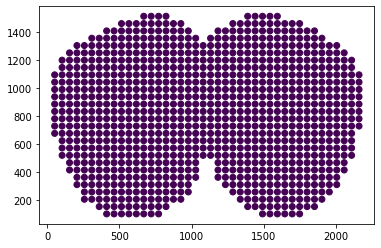

In [193]:
plt.scatter(grid_crd[:,0],grid_crd[:,1],c= mta)
plt.show()

In [260]:
ref = m.Reference(grid_crd,
                  landmarks = ref_lmk.values,
                  meta = dict(region = mta)
                 )

In [29]:
os.listdir(DATA_DIR)

['Rep5_MOB.h5ad',
 'Rep12_MOB.h5ad',
 'Rep4_MOB.h5ad',
 'Rep2_MOB.h5ad',
 'Rep1_MOB.h5ad',
 'Rep10_MOB.h5ad',
 'Rep7_MOB.h5ad',
 'Rep9_MOB.h5ad',
 'Rep6_MOB.h5ad',
 'Rep3_MOB.h5ad',
 'Rep11_MOB.h5ad',
 'Rep8_MOB.h5ad']

In [275]:
adatas = {p.split(".")[0]:ad.read_h5ad(osp.join(DATA_DIR,p)) for p in os.listdir(DATA_DIR)}
adatas = {f"Rep{k}_MOB" : adatas[f"Rep{k}_MOB"] for k \
          in sorted([ int(a.lstrip("Rep_").rstrip("_MOB")) for a in adatas.keys()])}

/home/alma/.local/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:182: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


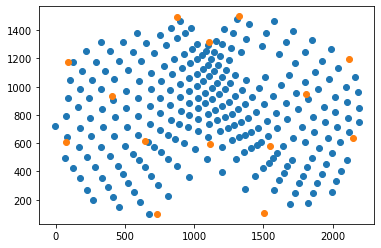

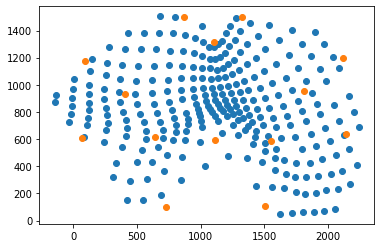

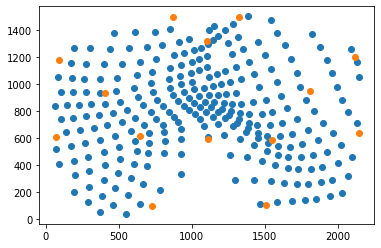

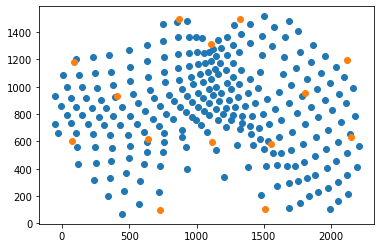

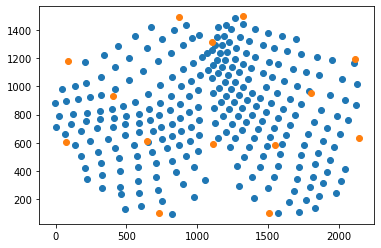

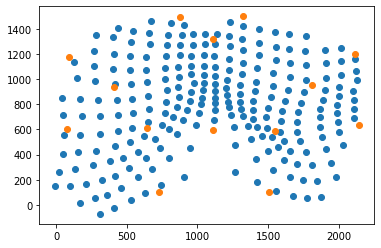

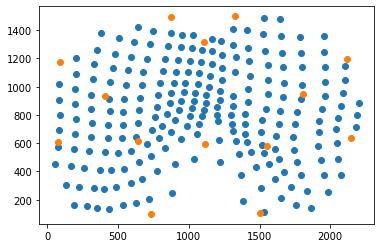

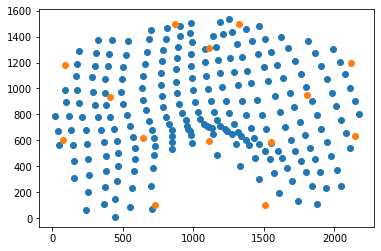

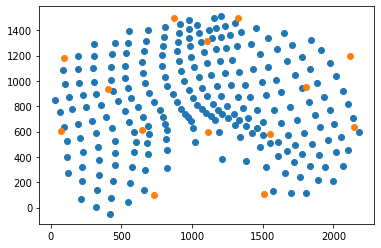

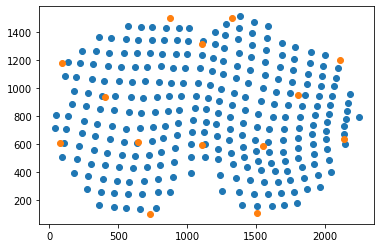

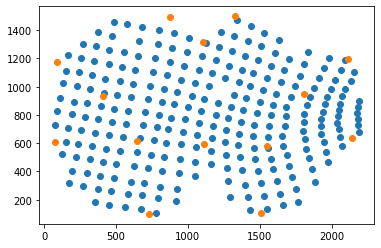

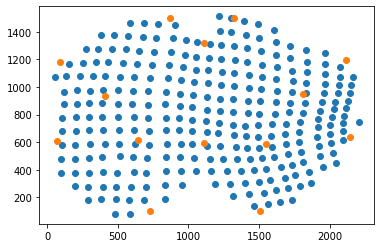

In [276]:
for adata in adatas.values():
    sc.pp.filter_genes(adata,min_cells = 0.1)
    sc.pp.normalize_total(adata,1e4,
                          exclude_highly_expressed = True)
    sc.pp.log1p(adata)
    sc.pp.scale(adata)
    pp.match_scales(adata,ref_lmk.values)
    pp.get_landmark_distance(adata,
                            reference=ref_lmk.values)    


In [132]:
from scipy.spatial.distance import cdist

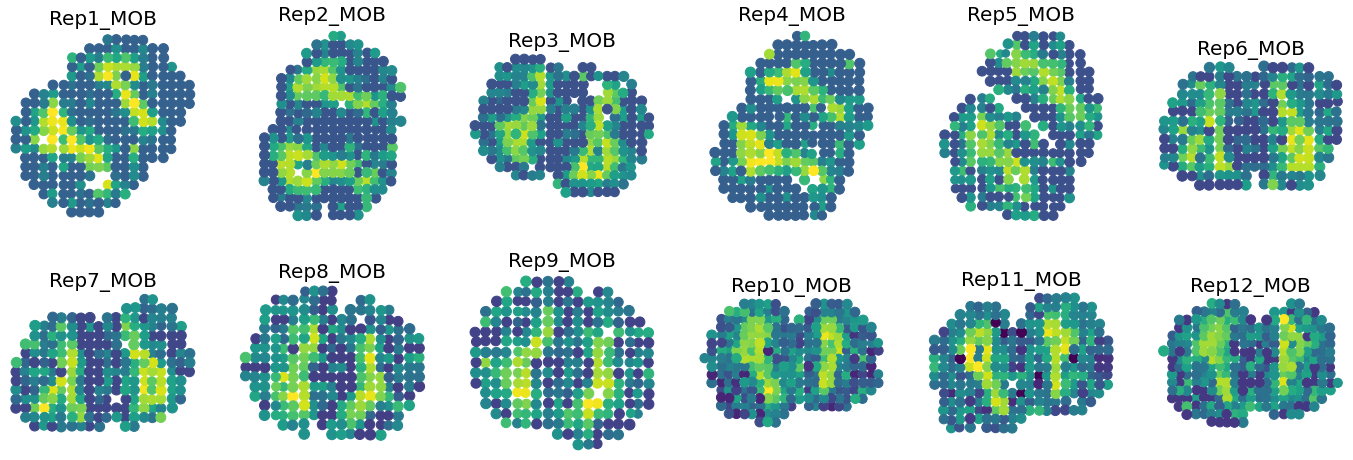

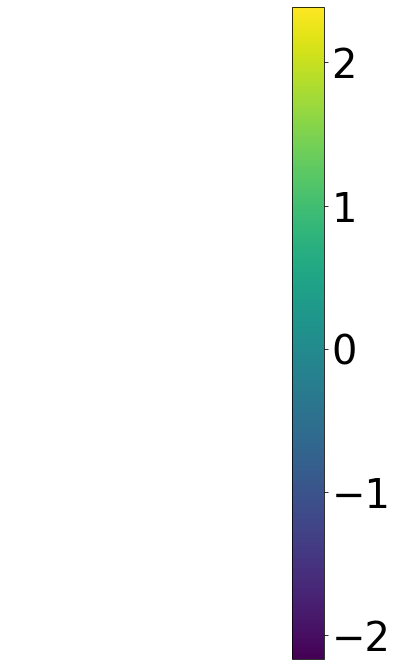

In [217]:
gene = "Nrgn"
marker_size  = 1.0
vmin = min([np.quantile(a.obs_vector(gene),0.01) for a in adatas.values()])
vmax = max([np.quantile(a.obs_vector(gene),0.99) for a in adatas.values()])
fig,ax = plt.subplots(2,6,figsize = (24,8))
ax = ax.flatten()
for k,(name,adata) in enumerate(adatas.items()):
    crd = adata.obsm["spatial"]
    delta = cdist(crd,crd)
    delta[delta == 0] = np.inf
    delta = np.min(delta,axis=1)
    _sc = ax[k].scatter(crd[:,0],
                  crd[:,1],
                  c = adata.obs_vector(gene),
                  vmin = vmin,
                  vmax = vmax,
                  cmap = plt.cm.viridis,
                  s = marker_size* delta ,
                 )
    ax[k].set_aspect("equal")
    ax[k].axis("off")
    ax[k].set_title(name,fontsize = 20)
plt.show()
fig,ax = plt.subplots(1,1,figsize=(6,12))
ax.axis("off")
cbar = fig.colorbar(_sc)
cbar.ax.tick_params(labelsize=40)
plt.show()

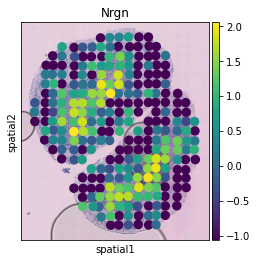

In [103]:
sc.pl.spatial(adatas[0],color = "Nrgn",spot_size=50)

In [261]:
models = f.map_to_reference(adatas,
                            "Nrgn",
                            ref,
                            n_epochs=1000,
                            device ="cuda",
                           )

In [243]:
import utils as ut
ut.spatial_smoothing(ref.adata)

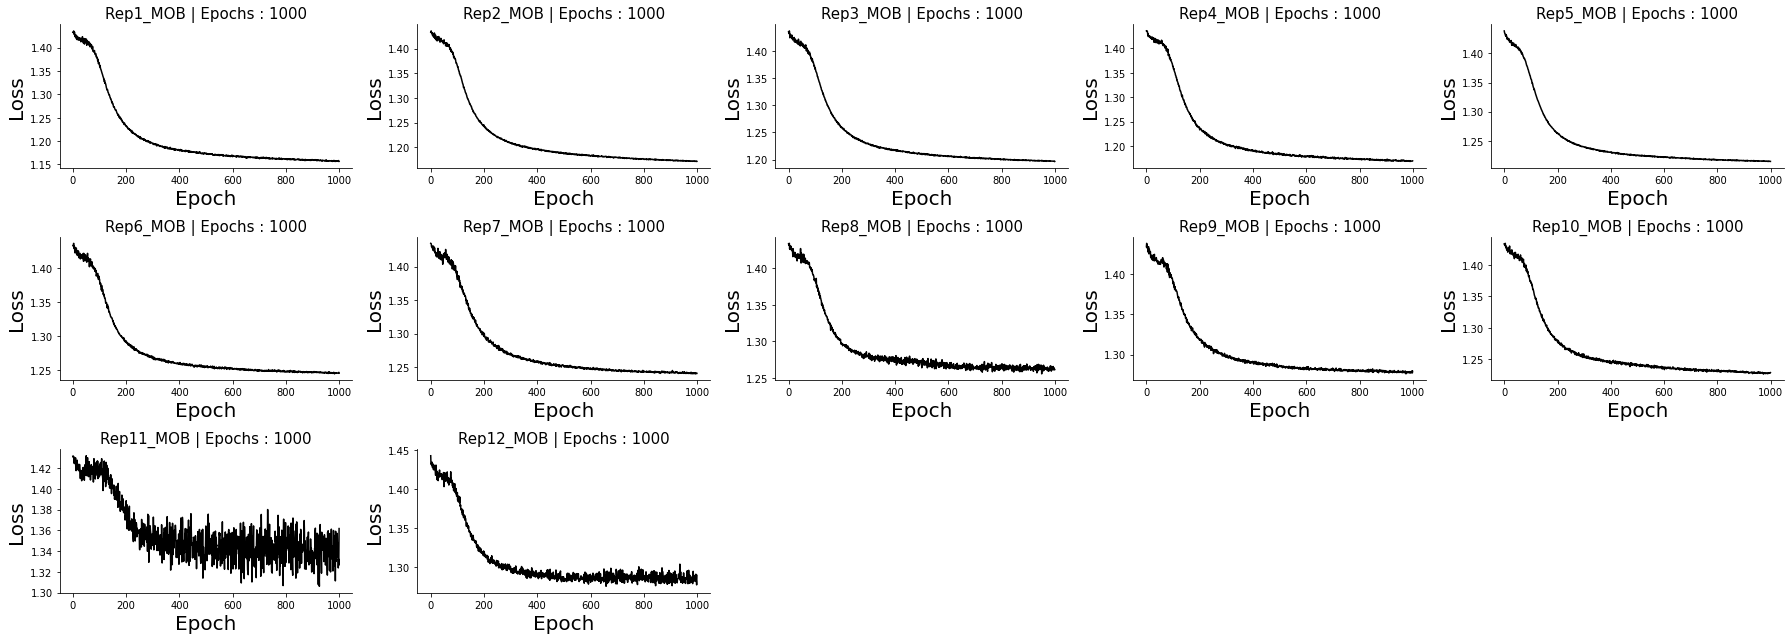

In [273]:
ut.model_diagnostics(models)

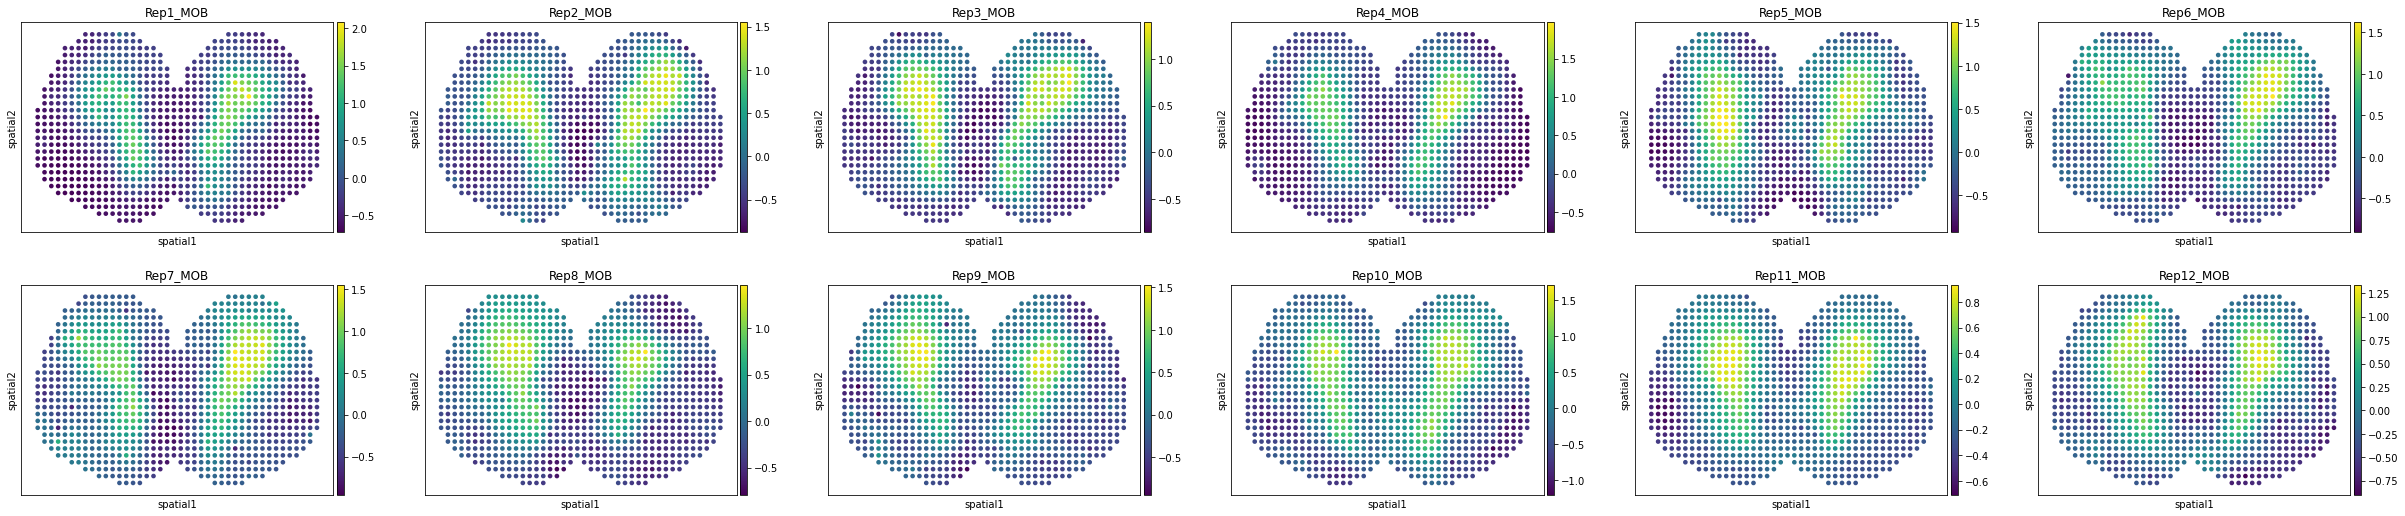

In [245]:
ref.plot(spot_size=35,cmap = plt.cm.viridis,ncols = 6)

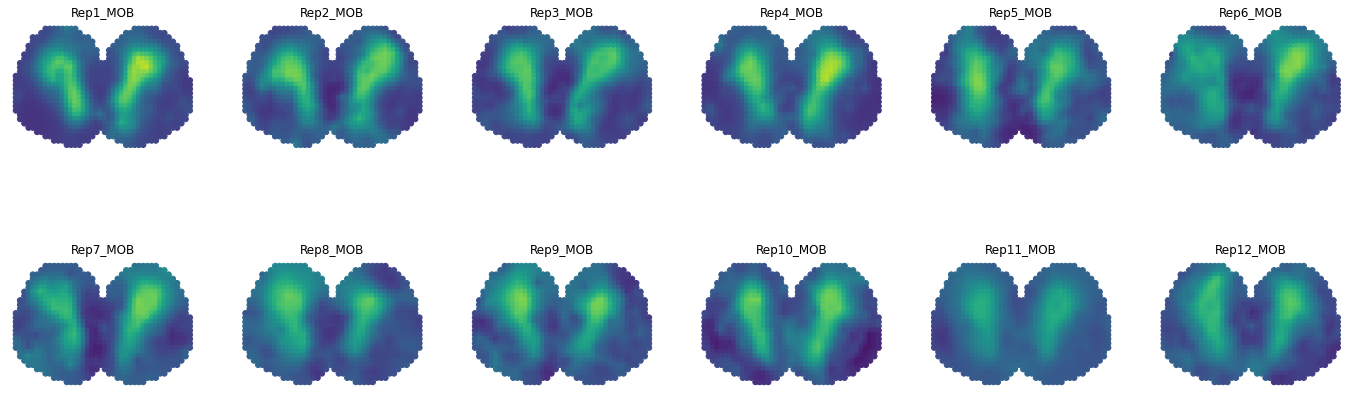

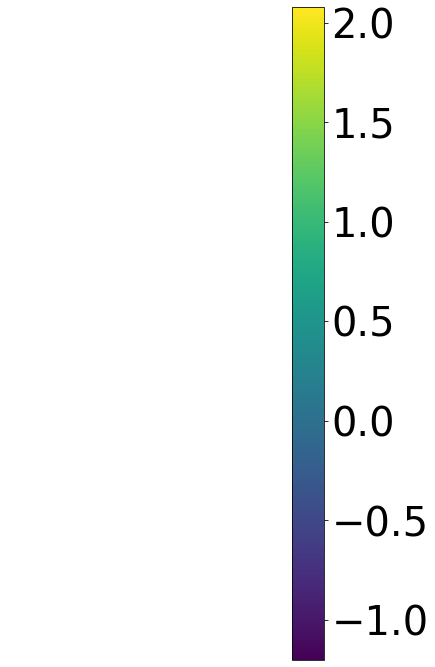

In [244]:
gene = "Nrgn"
marker_size  = 30
vmin = ref.adata.X.min()
vmax = ref.adata.X.max()
fig,ax = plt.subplots(2,6,figsize = (24,8))
ax = ax.flatten()
for k in range(ref.adata.shape[1]):
    crd = ref.adata.obsm["spatial"]
    _sc = ax[k].scatter(crd[:,0],
                  crd[:,1],
                  c = ref.adata.layers["smoothed"][:,k],
                  vmin = vmin,
                  vmax = vmax,
                  cmap = plt.cm.viridis,
                  s = marker_size,
                 )
    ax[k].set_aspect("equal")
    ax[k].axis("off")
    ax[k].set_title(ref.adata.var.index[k])
    ax[k].invert_yaxis()
    
fig,ax = plt.subplots(1,1,figsize=(6,12))
ax.axis("off")
cbar = fig.colorbar(_sc)
cbar.ax.tick_params(labelsize=40)
plt.show()

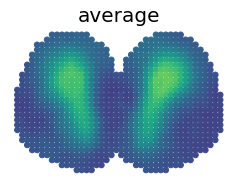

In [274]:
fig,ax = plt.subplots(1,1,figsize = (4,4))
crd = ref.adata.obsm["spatial"]
ax.scatter(crd[:,0],
           crd[:,1],
           c = ref.adata.X.mean(axis=1),
           vmin = vmin,
           vmax = vmax,
           cmap = plt.cm.viridis,
           s = marker_size,
          )
ax.set_aspect("equal")
ax.axis("off")
ax.set_title("average",fontsize = 20)
ax.invert_yaxis()
plt.show()

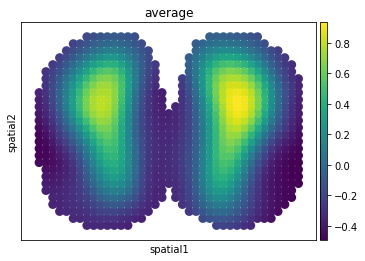

In [110]:
ref.plot("average",spot_size=35,cmap = plt.cm.viridis,ncols = 6)